<h1> Imports </h1>
All imports required for the program. 

In [2]:
# IV Classes Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import sys
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
from scipy.interpolate import interp1d

# Classifier Imports
from scipy.stats import describe
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import shutil

<h1> Classifier Class </h1>
This class can be used to classify datasets, if they need to be separated for further analysis. <br>
It uses a keras Sequential Neural Network (NN). The class can create a training dataset by giving the directory as input. <br>
Afterwards, only the labels need to be input manually in the features.xlsf file created. The NN learns from this file, and is stored on the machine and in the class. New data can be input later, which can be classified by the previously trained NN. 

In [3]:
class Classifier(object):
    '''
    Class that can be used to classify datasets based upon an existing Sequential model 
    or by creating a new model.
    Main Methods:
    create_features() - calculates features from a dataset, use in a loop to stack multiple datasets in a single file
    create_trainingdata() - creates training data for model by using the features, if no model is present the labels 
    to be classified must be added.
    create_NN() - creates a Sequential model that trains on the features and labels. The model is saved on the system and in the class itself.
    test_NN() - test the model on a features.xlsf file, all positive findings are put into a seperate directory
    '''
    def __init__(self, rootdir, model=None):
        self.rootdir = rootdir
        self.model = model
        self.iandv = pd.DataFrame()
        self.features = pd.DataFrame()
        
    def create_features(self, df, iandv, features, expnr, filelocation, filelocationlist):
        '''
        Helper function for create_trainingdata. 
        Creates features for a dataset. Can be used in a loop to gather multiple datasets 
        in a single features and iandv dataframe. To start off, iandv and features must empty DataFrame() 
        Returns df, iandv, features, expnr and filelocationlist.
        '''
        # Obtain IV columns and delete empty rows
        firsttwocol = df.iloc[:, [0, 1]].dropna()
        firsttwocol = firsttwocol.add_suffix(' ' + str(expnr))

        # Check if any of the two columns are not empty and check for enough data points
        if not firsttwocol.empty and len(firsttwocol.index) > 30:
            # make sure the plots aren't skewed, take mean of first and last n points to draw slope
            n = 10
            a = (np.mean(firsttwocol.iloc[(2 * -n):-n, 1]) - np.mean(firsttwocol.iloc[n:(2 * n), 1])) \
                / (np.mean(firsttwocol.iloc[(2 * -n):-n, 0]) - np.mean(firsttwocol.iloc[n:(2 * n), 0]))
            b = firsttwocol.iloc[:, 1] - a * firsttwocol.iloc[:, 0]
            firsttwocol.iloc[:, 1] = firsttwocol.iloc[:, 1] - a * firsttwocol.iloc[:, 0] + b

            # Obtain data
            iandv = pd.concat([iandv, firsttwocol], axis=1)
            stats = describe(firsttwocol.iloc[:, 1])
            gradient = np.gradient(firsttwocol.iloc[:, 1])
            statsgrad = describe(gradient)
            features = features.append([(stats.mean, stats.variance, stats.skewness, stats.kurtosis, statsgrad.mean,
                                         statsgrad.variance, statsgrad.skewness, statsgrad.kurtosis)])


            # Up the counter
            expnr += 1
            
            # Valid filelocations
            filelocationlist.append(filelocation)

        return df, iandv, features, expnr, filelocationlist
    
    def create_trainingdata(self, plot=False):
        '''
        Creates training data by using the features made in create_features(). 
        Labels need to be manually input in the features.xlsf file             
        NOTE: MIGHT CHANGE IN THE FUTURE!!
        '''
        # EXAMPLE: rootdir = r'C:\Users\arnol\Desktop\newproject\SAFARI TES data\Selection'
        Path(self.rootdir + r"\Plots").mkdir(parents=True, exist_ok=True)
        save_plots_to = self.rootdir + r'\Plots'
        filelocationlist = []

        iandv = self.iandv
        features = self.features
        expnr = 1
        errorcount = 0

        # Extract df, iandv, features, expnr from .qdp files
        for subdir, dirs, files in os.walk(self.rootdir):
            for file in files:
                ext = os.path.splitext(file)[-1].lower()
                if ext == '.qdp':
                    filelocation = os.path.join(subdir, file)
                    # If file cannot be read, display error
                    try:
                        df = read_qdp(filelocation)
                        df, iandv, features, expnr, filelocationlist = self.create_features(df, iandv, features, expnr, 
                                                                                            filelocation, filelocationlist)
                    except (pd.errors.ParserError, pd.errors.EmptyDataError):
                        errorcount += 1
                        print(filelocation)
                if ext == '.dat':
                    filelocation = os.path.join(subdir, file)
                    # If file cannot be read, display error
                    try:
                        df, params = read_dat(filelocation)
                        df, iandv, features, expnr, filelocationlist = self.create_features(df, iandv, features, expnr, 
                                                                                            filelocation, filelocationlist)
                    except (pd.errors.ParserError, pd.errors.EmptyDataError):
                        errorcount += 1
                        print(filelocation)

        print(str(expnr-1) + " files loaded")
        print("The above " + str(errorcount) + " file(s) were invalid and skipped, \
                        please check formats manually. Continuing...")

        # Output filelocationlist.txt
        filelocationlistfile = open('filelocationlist.txt', 'w')
        for filelocation in filelocationlist:
            filelocationlistfile.write(filelocation)
            filelocationlistfile.write('\n')
        filelocationlistfile.close()

        # Convert to .xlsx files
        iandv.to_excel('iandv.xlsx', index=False)
        features.columns = ['mean', 'std', 'skewness', 'kurtosis', 'grad mean', 'grad std', 'grad skewness', 'grad kurtosis']
        features = (features - features.mean()) / features.std()
        features.to_excel('features.xlsx', index=False)   
        
        # Plot all loaded datasets
        if plot:
            col_names = list(iandv)
            print(col_names)
            for i in range(0, 2*expnr - 3, 2):
                iandv.plot(kind='scatter', x=col_names[i], y=col_names[i+1], color='red')
                plt.savefig(save_plots_to + r'\row ' + str(int(i/2) + 1) + '.png', dpi=300)
                plt.close('all')
            
        # Update the initialised dataframes
        self.iandv = iandv
        self.features = features
                 
    def create_NN(self, rootfolder):
        '''
        Create a Sequential Neural Network to train on the labelled training data set. 
        Functions return nothing, as the model is saved on disk. 
        '''
        # EXAMPLE: rootfolder = r'C:\Users\arnol\Desktop\newproject'
        Y, Y_train, Y_test = {}, {}, {}

        # The eight feature columns are made in create_trainingdata() and are constant
        BEGIN_COLUMN_FEATURE = 0            
        END_COLUMN_FEATURE = 8              # This label needs to be 1 higher than the actual column label count

        # These depend upon how many labels are added and where they are added
        begin_column_label = 9
        end_column_label = 10               # This label needs to be 1 higher than the actual column label count

        # load the dataset
        dataset = pd.read_excel(os.path.join(rootfolder, r'features.xlsx'))
        print(dataset.head())

        # Split into input (X) and output (Y) variables
        X = dataset.iloc[:, :END_COLUMN_FEATURE]  # Up to and not including column 8

        # For each label, the model is trained with 150 epochs
        for i in range(begin_column_label, end_column_label):  # Label columns
            Y[i] = dataset.iloc[:, i]

            # Split in training and testset
            X_train, X_test, Y_train[i], Y_test[i] = train_test_split(X, Y[i], test_size=0.2)

            # Define the keras model
            model = Sequential()
            model.add(Dense(12, input_dim=8, activation='relu'))
            model.add(Dense(8, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))

            # Compile the keras model
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            # Fit the keras model on the training dataset
            model.fit(X_train, Y_train[i], epochs=150, batch_size=10)

            # Make class predictions with the model for data X_test
            predictions = model.predict_classes(X_test)

            # Give accuracy for all data input cases
            for j in range((len(X_test))):
                print('%s => %d (expected %d)' % (X_test.iloc[j].tolist(), predictions[j], Y_test[i].iloc[j]))

            # Print confusion matrix
            print("Confusion matrix:\n", confusion_matrix(Y_test[i], predictions, labels=None, sample_weight=None,
                                                          normalize=None))
            # Save models
            model.save('model ' + dataset.columns[i])
            self.model = model

        print("Saved models to disk")
        return model
                         
    def test_NN(self, rootfolder):
        '''
        Test the NN made in create_NN(). All datasets that were tested positively are deposited 
        in a seperate depository for analysis. Functions returns nothing.
        '''
        #rootfolder = r'C:\Users\arnol\Desktop\newproject'

        BEGIN_COLUMN_FEATURE = 0  # remember python starts counting at 0
        END_COLUMN_FEATURE = 8

        begin_column_label = 9
        end_column_label = 10  # change this line to add more classes

        positivenrlist = []
        qspname = open('filelocationlist.txt', 'r')
        qsp_data = qspname.readlines()

        for i in range(begin_column_label, end_column_label):

            # Load dataset
            dataset_uncut = pd.read_excel(os.path.join(rootfolder, r'features.xlsx'))
            dataset = dataset_uncut.iloc[:, :END_COLUMN_FEATURE]

            # Load model    
            if self.model != None:
                model = self.model
            else:
                model = load_model('model ' + dataset_uncut.columns[i])

            # Evaluate the model
            predictions = model.predict_classes(dataset)

            for j in range((len(dataset))):
                if predictions[j] == 1:
                    positivenrlist.append(str(j + 2))  # + 2 so 0 becomes 2 to correspond to features.xlsx file rows
            print("The following rows were tested positive for " + dataset_uncut.columns[i]
                  + ': ' + ', '.join(positivenrlist))
            print("The corresponding .qsp filenames are stored in Positive " + dataset_uncut.columns[i] +
                  ' and copied to the Positives folder.')

            positivenamelist = open('Positive ' + dataset_uncut.columns[i] + '.txt', 'w+')
            for number in positivenrlist:
                positivenamelist.write(qsp_data[int(number) - 2])  # - 2 to account for previous + 2
            positivenamelist.close()

            # Copy all the .qsp files that were tested positive to their designated folders
            #target = os.path.join(rootfolder, r'SAFARI TES data\Selection\positives', dataset_uncut.columns[i])
            target = os.path.join(rootfolder, dataset_uncut.columns[i])
            if not os.path.exists(target):
                os.mkdir(target)

            positivenamelist = open('Positive ' + dataset_uncut.columns[i] + '.txt', 'r+')
            for line in positivenamelist.readlines():
                shutil.copy(line.strip(), target)
            positivenamelist.close()

            positivenrlist.clear()

        qspname.close()

<h1>IV_curve_double Class</h1>
Each dataset is stored inside an <code>IV_curve</code> class.
This class contains different methods to calculate certain values and plot different characteristics of the dataset

In [4]:
class IV_curve_double(object):
    '''
    Main Methods:
    self.calc_all() - Calculates all important values and parameters
    self.plot_IV() - plots IV graph
    self.plot_PV() - Plot PV graph
    self.plot_PR() - plots PR graph
    '''
    
    def __init__(self, rawIV, params = 0, name='NA', tweaks = [1,1,1]):
        ''' Creates a TES object from a pandas dataframe. 
        
        Reads the first two columns of the dataframe and saves them as attributes. Next two columns will 
        be checked for T_BB and T_bath variables, but will be set to zero when not found. 
        Params can be a list or tuple of values in this order [R_fb, M_ratio, R_shunt]
        R_stray can be included as extra paramter. Doing so will prevent the calc_R_stray method being used to 
        generate a value.
        
        Attributes after initialisation:
        rawI (np.array[floats]), rawV (np.array[floats])
        raw_grad/raw_2grad (list[floats]) - 1st and 2nd differentials of rawIV
        superconducting (bool) - Whether the data shows signs of superconductivity
        y_offset (float) - Offset in the 
        I_TES (list[floats]), V_bias (list[floats]) - Calibrated data
        R_fb, M_ratio, R_shunt (floats)- Experimental parameters
        gain (float) - Calculated from M_ratio and R_fb
        R_stray (float) - Either input or calculated
        P_TES , R_TES (floats) - Power and Resistance values
        rnn (float) 
        
        ohmic_reg, trans_reg, super_reg (ints) the demarcated regions. 
        If not super conducting ohmic_reg will be the entire data range.
        '''
        
        # Raw data
        self.df = rawIV
        
        # Drop NaNs in spreadsheet to prevent errors later 
        rawI = (rawIV.iloc[:,0].dropna()).values  # Store as individual np.arrays for more readable code
        self.rawI = [entry * tweaks[0] for entry in rawI]
        rawV = (rawIV.iloc[:,1].dropna()).values
        self.rawV = [entry * tweaks[1] for entry in rawV]
        
        # Search next columns for T_BB and T_bath, if non existent set them to 0.1 
        try:
            # OLD
            #self.T_BB = rawIV.iloc[:,3].dropna().values
            #self.T_bath = rawIV.iloc[:,4].dropna().values
            
            self.T_BB = rawIV.iloc[:,3].dropna().values
            self.T_bath = rawIV.iloc[:,2].dropna().values
        except IndexError:
            print("T_BB and T_bath not found")
            self.T_BB = 0.1
            self.T_bath = 0.1
            
        self.P = False
        
        # Obtaining Power Data if present in the raw data
        try:
            assert len(rawIV.columns) > 5
            self.P_BB = (rawIV.iloc[:,-1]).dropna()
            for entry in self.P_BB:
                if entry != 0:
                    self.P = True
        except:             # Find out which exeption (AssertionError or IndexError)
            print("Failed to parse Power Data")
        
        self.raw_grad = np.gradient(self.rawV, self.rawI) # Prevents repeated calls to gradient function later
        self.raw_2grad = np.gradient(self.raw_grad, self.rawI)
        self.superconducting = self.calc_superconducting() # This needs to be done first as other inits depend on it
        
        # Initialise these values with the methods
        self.name = name
        self.y_offset = 0
        
        # Parameters needed to calculate V_bias and I_TES. Defaults are used when not provided. 
        # I DO NOT KNOW WHERE THESE DEFAULT NUMBERS ARE BASED ON, ASK CALLUM
        if params:
            try:
                self.R_fb = params[0]
                self.M_ratio = params[1]
                self.R_shunt = params[2]
            except IndexError:
                print("Error: Parameters not correct")
                return
        else:
            print("WARNING: Using default parameters")
            self.R_fb = 100099.6
            self.M_ratio = 18.9333333333333
            self.R_shunt = 0.00389
        
        self.gain = 1 / (self.R_fb * self.M_ratio)
             
    ############################# Calculation Methods ##########################################   
    # For formulas see Callum's Thesis
    
    def calc_I_TES(self, tweak=1):
        '''
        Generate I_TES (array) data from the y_offset (float), gain (float) and voltage (array).
        '''
        self.I_TES = [(self.rawV[i] - self.y_offset) * (10**6) * self.gain for i in range(len(self.rawV))]
        
    def calc_V_bias(self, tweak=1):
        '''
        Generate V_bias (array) data from R_shunt (float), R_stray(float), rawI (array) and I_TES (array)
        '''
        self.V_bias = [((self.rawI[i]) * self.R_shunt) - (self.I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
        
    def calc_P_TES(self):
        '''
        Generate P_TES (array) data from I_TES (array) and V_bias (array) 
        '''
        self.P_TES = [self.I_TES[i] * self.V_bias[i] for i in range(len(self.I_TES))]
        
    def calc_R_TES(self):
        '''
        Generate R_TES (array) data from V_bias (array) and I_TES (array)
        '''
        self.R_TES = [self.V_bias[i] / self.I_TES[i] for i in range(len(self.V_bias))]
        
    def calc_superconducting(self):
        '''
        Tests if the gradient deviates from the average by a significant margin. And save result in attribute.
        Returns the boolean value of self.superconducting
        NOTE: Might be deprecated after classifying is introduced
        '''
        grad = self.raw_grad
        grad_av = sum(grad)/len(grad)
        if abs(min(grad)) > 2*(grad_av) and min(grad) < 0:
            self.superconducting = True
        else:
            self.superconducting = False
    
        return self.superconducting
    
    def calc_all(self):
        '''
        Calculates all values used for the plots and analysis.
        NOTE: Maybe implement calc_rnn func, so it doesn't need to be done in the plotIV function
        '''       
        self.power_readout()
        self.calc_I_TES()
        self.calc_V_bias()
        self.plot_IV(False)
        self.reverse_y_offset()
        
        self.calc_I_TES()
        self.calc_V_bias()
        self.plot_IV(False)
        self.calc_P_TES()
        self.calc_R_TES()
        self.power_readout(True)
    
    ############################ Utility methods ############################   
    
    def f_exp(self, x, A, B, C, D, x0):
        return A*x + B + (x/np.abs(x))*C*np.exp(-D*(np.abs(x)-x0))
        
    def fit_ohmic(self, x_data, y_data, nfit, debug=False):
        ''' 
        Accepts two lists for X and Y vals and a tuple of indices. These are then used 
        to fit a straight line to the straight regions.
        Returns C, D, xvals. Which are the gradient, intercept and range of the fitted curve.
        '''
    
        # Minimum and maximum x values used for plotting later on
        firstx1, lastx1 = min(x_data[:nfit]), max(x_data[:nfit])
        firstx2, lastx2 = min(x_data[-nfit:]), max(x_data[-nfit:])

        # Slice the data in the frame and store in an array 
        yvals1 = y_data[:nfit]
        yvals2 = y_data[-nfit:]
        lineDataY = np.append(yvals1, yvals2)
        
        xvals1 = x_data[:nfit]
        xvals2 = x_data[-nfit:]
        lineDataX = np.append(xvals1, xvals2)
        
        # Fit the exponential function to the sliced data 
        popt1, pcov1 = curve_fit(self.f_exp, xvals1, yvals1, 
                               p0=[4.5, 0.01, -0.5, 100, 0.02], bounds=((4, 0, -1, 0, 0), (5, 0.05, 1, 200, 0.1)))
        popt2, pcov2 = curve_fit(self.f_exp, xvals2, yvals2, 
                               p0=[4.5, 0.01, 0.5, 100, 0.02], bounds=((4, 0, 0, 0, 0), (5, 0.05, 1, 200, 0.1)))
        
        # Create regularly spaced x values and calculate the y values with the fit 
        x_func_vals1 = np.linspace(firstx1, lastx1, 100)
        y_func_vals1 = self.f_exp(x_func_vals1, popt1[0], popt1[1], popt1[2], popt1[3], popt1[4])
        
        x_func_vals2 = np.linspace(firstx2, lastx2, 100)
        y_func_vals2 = self.f_exp(x_func_vals2, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4])
        
        # Save them in a list and export them together with the fit parameters
        x_func_vals = [x_func_vals1, x_func_vals2]
        
        if debug:
            plt.scatter(xvals1, yvals1, s=2)
            plt.scatter(xvals2, yvals2, s=2)
            plt.plot(x_func_vals1, y_func_vals1, color='r')
            plt.plot(x_func_vals2, y_func_vals2, color='g')
            params_label = "A: "+str(popt1[0])+"\nB: "+str(popt1[1])+"\nC: "+str(popt1[2])+"\nD: "+str(popt1[3])+"\nx0: "+str(popt1[4])
            plt.plot([], [], ' ', label=params_label)
            #plt.ylim(0.9*min(self.I_TES), 1.1*max(self.I_TES))
            plt.legend()
            plt.show()
        
        return popt1, popt2, x_func_vals
    
    def power_readout(self, plot=False):
        '''
        Looks for turning points from positive to negative gradient, as that denotes a different region.
        RETURNS: indices of the turning points and the corresponding power values
        '''
        indices = []
        
        # Look for three consecutive negative gradients and add the index of the first point to a list
        count = 0 
        for index in range(len(self.raw_grad)):
            if self.raw_grad[index] < 0:
                count += 1
            else:
                count = 0
                
            if count >= 3:
                indices.append(index-count)
                break
        
        # Same procedure but from the other side
        # NOTE: IMPLIES SYMMETRY, CHECK FOR SINGLE SIDED???
        count = 0
        for index in range(len(self.raw_grad)):
            if self.raw_grad[-index] < 0:
                count += 1
            else:
                count = 0
                
            if count >= 3:
                indices.append(-(index-count))
                break
        
        # Dependent upon the amount of points, change readout value
        readout = 0  
        if plot:
            if len(indices) == 2:
                readout = (self.P_TES[indices[0]] +  self.P_TES[indices[1]])/2
            elif len(indices) == 1:
                readout = self.P_TES[indices[0]]
            else:
                readout = 0
        
        self.readout_idx = indices
        self.readout = readout
        return readout
    
    def reject_outliers(self, data, m=2.):
        '''
        Rejects outliers from the dataset, look into how it works!!!
        '''
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
    def y_search(self, step, pivot, precision):
        '''
        Recursive function where the step gets lowered continously until it is at the 
        provided precision level. Returns pivot, the y_offset.
        '''
        ys = []
        counts = []
        
        # Recursive loop end 
        if step <= precision:
            self.y_offset = pivot
            return pivot
        
        # Loop over a small range of values around pivot, and saves value with lowest count
        for y_off in np.arange(pivot-(step*10), pivot+(step*10), step/10):
            # Necessary calculations for R_TES and P_TES
            I_TES = [(entry - y_off) * (10**6) * self.gain for entry in self.rawV]
            V_bias = [((self.rawI[i]) * self.R_shunt) - (I_TES[i]*(self.R_shunt + self.R_stray)) for i in range(len(self.rawI))]
            P_TES = [I_TES[i] * V_bias[i] for i in range(len(I_TES))]
            P_grad = np.gradient(P_TES)
            P_grad_smooth = self.reject_outliers(P_grad)
            R_TES = [V_bias[i] / I_TES[i] for i in range(len(V_bias))]
            
            #  
            count = 0          
            for i in range(int(len(R_TES)/10)-1):
                count += np.sqrt((R_TES[i] - R_TES[-i])**2)
                count += (R_TES[i] - self.rnn)**2
                count += (R_TES[-i] - self.rnn)**2
                
            count += len(R_TES)*(self.rnn - max(R_TES))**2
            
            for entry in P_TES:
                if entry < 0:
                    count += 10 * (entry**2)
            
            for entry in R_TES:
                if entry < 0:
                    count += 10 * (entry**2)
            
                
            counts.append(count)
            ys.append(y_off)

        y_offset = ys[np.argmin(counts)]

        return self.y_search(step/10, y_offset, precision)
    
    def reverse_y_offset(self):
        '''
        Requires R_stray to have been already calculated or input.
        Attempts to calc offset through optimising the power plot. 
        '''
        self.y_search(5,0,0.000001)
    
    ############### Plotting Methods ###################
    
    def plot_Raw(self):
        '''
        Plots raw IV data 
        '''
        plt.scatter(self.rawI, self.rawV, label='Raw IV', s=3)
        plt.grid()
        plt.xlabel(r"$ I_{bias}$ (μA)")
        plt.ylabel(r"$ V_{fb}$ (V)")
        plt.title(self.name)
        plt.show()
        
    def plot_IV(self, plot=True):
        '''
        Plots the calibrated IV curve if plot is set to true. Otherwise just calcs R_nn
        '''
        popt1, popt2, x_func_vals = self.fit_ohmic(self.V_bias, self.I_TES, 60)
        self.rnn = 1 / ((popt1[0] + popt2[0])/2)
        if plot:
            fig, ax = plt.subplots()
            plt.grid()
            plt.scatter(self.V_bias, self.I_TES, label='TES IV', s=3)
            plt.plot([], [], ' ', label="Rnn ($\Omega$): "+str(self.rnn))
            
            if len(self.readout_idx) == 2:
                plt.scatter([self.V_bias[self.readout_idx[0]], self.V_bias[self.readout_idx[1]]], [self.I_TES[self.readout_idx[0]], self.I_TES[self.readout_idx[1]]])
            
            y_func_vals1 = self.f_exp(x_func_vals[0], popt1[0], popt1[1], popt1[2], popt1[3], popt1[4])
            y_func_vals2 = self.f_exp(x_func_vals[1], popt2[0], popt2[1], popt2[2], popt2[3], popt2[4])
            
            plt.plot(x_func_vals[0], y_func_vals1, color='r')
            plt.plot(x_func_vals[1], y_func_vals2, color='g')
            
            ax.set_xlabel("Bias Voltage (mV)")
            ax.set_ylabel("TES Current (mA)")
            plt.title("Calibrated IV Curve")
            ax.legend()
            plt.show()          
            
    def plot_PR(self, name=''):
        '''
        Plots the Power - Resistance curve
        '''
        fig = plt.figure()
        plt.grid()
        plt.plot(self.R_TES, self.P_TES, label='TES Power-Resistance Curve')
        plt.title("Power vs Resistance Curve")
        plt.xlabel(r"TES Resistance ($\Omega$)")
        plt.ylabel("TES Power (fW)")
        
        if self.calc_superconducting():
            readout = self.power_readout(True)
            plt.axhline(readout, color='g', label='Joule Power (fW): '+ str(round(readout, 5)))
        
        plt.axvline(self.rnn, color='r', label=r'$R_{nn} (\Omega)$: ' + str(round(self.rnn,5)))
        plt.legend()
        plt.savefig("PR_d_good.png", dpi=300)
        plt.show()
    
    def plot_PV(self):
        fig, ax = plt.subplots()
        plt.grid()
        plt.scatter(self.V_bias, self.P_TES, label='TES PV', s=3)
        plt.title("Power - Voltage Curve")
        ax.set_xlabel("Bias Voltage (mV)")
        ax.set_ylabel("TES Power (fW)")
        
        if self.superconducting:
            readout = self.power_readout(True)
            plt.axhline(readout, color='g',label=round(readout,5))
        
        plt.legend()
        plt.show()

<h1> IV_curve_single Class </h1>
Similar as the previous class, except due to additional parameters the methods are calculated differently

In [5]:
class IV_curve_single(object):
    '''
    Main Methods:
    self.calc_all() - Calculates all important values and parameters
    self.plotIV() - plots IV graph
    self.plotPR() - plots PR graph
    '''
    
    def __init__(self, df, params, name='na'):
        ''' 
        Creates object from dataframe and dictionary. 
        Dataframe df contains the raw data in 3 columns: V_bias, V_fb, Phase.
        Dictionary params contains all parameters that can be obtained in the filelist and 
        in the raw .dat files.
        
        For calculation, all constants calculated will be stored inside params, except for jump_index 
        and IV_min. 
        All calculated arrays will be stored as self.array_name.
        '''
        
        # Initialize df and separate the input values
        self.df = df
        self.V_bias = df['V_bias'] / 1000               # V_bias in Volts
        self.V_fb = df['V_fb'] / 1000                   # V_fb in Volts
        self.phase_angle = df['Phase']                  # Phase angle in radians
        self.phase_rad = self.phase_angle * np.pi/180   # Phase angle in degrees
        # In notebook phase is divided by phase[0], why???
        
        # self.params contains all constants and other variables. 
        # For all variables use self.params.keys()
        self.params = params
        self.name = name
        
        # Convert bath temperature from mK to K
        self.params['T_bath'] = self.params['T_bath'] / 1000
        
        # Check if dataset is dark or optical
        if self.params['T_BB'] > 4:
            self.params['dark'] = False
        else:
            self.params['dark'] = True
       
    ############################# Calculation Methods ##########################################
    
    def calc_params(self):
        ''' 
        Creates the jump index from transition to superconducting and the 
        lowest point on the IV curve and stores in self.
        '''
        # Index where TES goes superconducting
        jump_index = np.gradient(self.I_TES).argmax() - 1 
        self.jump_index = jump_index  
        
        # lowest point of IV curve, used as fudicial point for saturation power of TES
        IV_min = np.argmin(self.I_TES[:jump_index])
        self.IV_min = IV_min
    
    def calc_I_TES(self):
        ''' 
        Generates I_TES (array) from the feedback voltage (array) and some constants (floats). 
        ''' 
        self.I_TES = self.V_fb*self.params['FB_corr'] / (self.params['R_fb']*self.params['M_ratio']*np.sqrt(8))
        
    def calc_values(self):
        ''' 
        Calculates R_TES, V_TES, P_TES and Joule power. 
        Requires I_TES, IV_min and fit_exp_bias. Returns nothing. 
        '''
        # Calculate the voltage across the LC filter and TES in series:
        VLC = self.V_bias*(self.params['R_N']+self.params['Rpar']) / self.params['RC_n']
        self.VLC = VLC
        
        # Calculate the total resistance of the LC filter and TES in series:
        RLC = VLC / self.I_TES
        self.RLC = RLC
        
        # Calculate the TES resistance (R_TES) in ohms:
        R_TES = RLC - self.params['Rpar']
        self.R_TES = R_TES

        # Calculate the voltage across the TES (V_TES) in V:
        V_TES = self.I_TES * R_TES
        self.V_TES = V_TES

        # Calculate the power dissipated in the TES (P_TES) in fW:
        P_TES = V_TES*self.I_TES*1.e15
        self.P_TES = P_TES

        # Calculate the Joule power (P_Joule) at the fiducial point (minimum of the IV curve):
        P_Joule = P_TES[self.IV_min]
        self.P_Joule = P_Joule
    
    def calc_all(self, debug=False):
        ''' 
        Calculate all important values and parameters in the right order. 
        Set debug to True to obtain intermediary results for fitting.
        Returns nothing.
        '''
        self.calc_I_TES()
        self.calc_params()
        
        # Number of points used for fitting. Includes small part of transition and all of ohmic.
        I_TES_no_s = self.I_TES[:self.jump_index]
        nfit1 = int(0.2*len(I_TES_no_s[self.IV_min:]))
        nfit2 = len(I_TES_no_s[:self.IV_min])                 
        nfit = nfit1 + nfit2
        
        self.fit_exp_bias(self.V_bias, self.I_TES, nfit, debug=debug)
        self.calc_values()
        self.fit_exp_TES(self.V_TES, self.I_TES, nfit, debug=debug)
        
    ################################# Utility methods #########################################  
        
    def f_exp(self, x, A, B, C, D, x0):
        return A*x + B + C*np.exp(-D*(x-x0))
    
    def fit_exp_bias(self, x_data, y_data, nfit, debug=True):
        ''' 
        Fit exponential func on slice of data that is provided as input. 
        Stores RC_n, Rpar and other parameters in self.params.
        Setting debug to True shows the fitting results.
        Returns the fitting parameters popt. 
        '''
        # Split dataset up to nfit, or up to the jump index if nfit is bigger
        if nfit > self.jump_index:
            xvals = x_data[:self.jump_index] 
            yvals = y_data[:self.jump_index] 
            print("Nfit Limit Reached: Cannot be bigger than " + str(self.jump_index))
        else:
            xvals = x_data[:nfit] 
            yvals = y_data[:nfit] 
            
        # Convert y data to nano units for better fit accuracy
        xvals = xvals 
        yvals = yvals * 1.e9
        
        # Fitting bounds and guesses 
        A_g = (yvals[0]-yvals[50])/ (xvals[0]-xvals[50])  # Slope guess
        x0_g = xvals[self.IV_min]                         # x0 guess
        guess = [A_g, 0, 2.5, 0.15, x0_g]
        bound = ((0.5*A_g, -100, 0, 0, 0.8*x0_g), (1.5*A_g, 100, 100, 100, 1.2*x0_g))
        
        # Try fitting within bounds. If it fails, use the more general but less precise method.
        # If that is the case make sure the fitting method went right by setting debug=True
        try:
            popt, pcov = curve_fit(self.f_exp, xvals, yvals, p0=guess, bounds=bound)
        except RuntimeError:
            print("Could not fit within bounds, recalculating without bounds...")
            popt, pcov = curve_fit(self.f_exp, xvals, yvals, p0=guess, maxfev=10_000_000)
        
        # Extract Fitting parameters and calculate the RC_n value
        A, B, C, D, x0 = popt[0] , popt[1], popt[2], popt[3], popt[4]
        RC_n = 1 / (A* 1.e-9)
        
        # Store parameters in dictionary
        self.params['RC_n'] = RC_n 
        self.params['slope_n'] = A * 1.e-9
        self.params['intercept_n'] = B * 1.e-9
        
        # set debug to true for plotting the fitting results
        if debug:
            # x and y values for plotting fitted curve            
            x_func_vals = xvals
            y_func_vals = self.f_exp(x_func_vals, A, B, C, D, x0)
            
            plt.scatter(xvals, yvals, s=2)
            plt.plot(x_func_vals, y_func_vals, color='r', alpha=0.8)
            params_label = "A: "+str(A)+"\nB: "+str(B)+"\nC: "+str(C)+"\nD: "+str(D)+"\nx0: "+str(x0)+"\nRC_n: "+str(RC_n)+" ohm"
            plt.plot([], [], ' ', label=params_label)
            plt.xlabel("Voltage Bias (V)")
            plt.ylabel("TES Current (nA)")
            plt.legend()
            plt.show()
            
        # Fit a loadline to the superconducting part
        loadline_points_s = 10
        force_loadline_s_through_origin = True
        if self.params['force_Rpar'] > 0:
            Rpar = IVcurve['force_Rpar']
            if debug:
                print('Have got Rpar as '+repr(Rpar)+' from list file')
            RC_sc = Rpar*RC_n / (Rpar+self.params['R_N'])
            slope_s = 1/RC_sc
            intercept_s = 0.
            if debug:
                print('Have set Rpar to '+repr(Rpar)+' from list file')
        else:
            if debug:
                print('It doesnt like Rpar from list file')
            if(force_loadline_s_through_origin):
                slope_s = np.average(y_data[-loadline_points_s:-2]/x_data[-loadline_points_s:-2])
                intercept_s = 0
            else:
                slope_s, intercept_s = np.polyfit(x_data[-loadline_points_s:],
                                            y_data[-loadline_points_s:],1)

            RC_sc = 1 / slope_s

            # Calculate the stray resistance, $R_{\rm par}$:
            Rpar = self.params['R_N']*RC_sc/(RC_n-RC_sc)

        loadline_s = slope_s*x_data + intercept_s
        self.params['loadline_s'] = loadline_s
        self.params['Rpar'] = Rpar

        if debug:
            plt.scatter(x_data, y_data, s=3)
            label = "A: "+str(slope_s)+"\nB: "+str(intercept_s)+"\nRC_sc: "+str(RC_sc)+" Ohm\nRpar: "+str(Rpar)+" Ohm"
            plt.plot(x_data, loadline_s, color='r', label=label)
            plt.ylim(min(loadline_s[-loadline_points_s:-2]), max(loadline_s[-loadline_points_s:-2]))
            plt.legend()
            plt.show()

        return popt
    
    def fit_exp_TES(self, x_data, y_data, nfit, debug=True):
        ''' 
        Fit exponential func on slice of data that is provided as input.
        Stores RC_n, Rpar and other parameters in self.params.
        Setting debug to True shows the fitting results. 
        Returns the fitting parameter popt.
        '''
        # Split dataset up to nfit, or up to the jump index if nfit is bigger
        if nfit > self.jump_index:
            xvals = x_data[:self.jump_index] 
            yvals = y_data[:self.jump_index] 
            print("Nfit Limit Reached: Cannot be bigger than " + str(self.jump_index))
        else:
            xvals = x_data[:nfit] 
            yvals = y_data[:nfit] 
            
        # Convert data to nano units for better fit accuracy
        xvals = xvals * 1.e9
        yvals = yvals * 1.e9
        
        # First bounds are proper bounds the FDM data directory 
        # Fit the function within these parameter bounds, use larger bounds if it wont fit
        try:
            bound = ((4, 0, 0, 0, 50), (11, 100, 20, 0.5, 70))
            popt, pcov = curve_fit(self.f_exp, xvals, yvals, 
                                   p0=[6.2, 50, 2.5, 0.14, 60], bounds=bound)
        except RuntimeError:
            print("Could not fit within bounds, recalculating without bounds...")
            A_g = (y_data[0]-y_data[10])/ (x_data[0]-x_data[10])
            guess = [A_g, 0, 2.5, 0.15, 60]
            bound = ((0.5*A_g, -50, 0, 0, 0), (1.5*A_g, 50, 20, 0.5, 200))
            popt, pcov = curve_fit(self.f_exp, xvals, yvals, p0=guess, bounds=bound)
            
        # Extract Fitting parameters and calculate the R_N value
        A, B, C, D, x0 = popt[0], popt[1], popt[2], popt[3], popt[4]
        R_N_calc = 1 / A
        
        # Store parameters in dictionary
        self.params['R_N_calc'] = R_N_calc
        self.params['slope_TES_n'] = A
        self.params['intercept_TES_n'] = B * 1.e-9
        
        # Set debug to True for plotting the fitting results
        if debug:
            # x and y values for plotting fitted curve            
            x_func_vals = xvals
            y_func_vals = self.f_exp(x_func_vals, A, B, C, D, x0)
            
            plt.scatter(xvals, yvals, s=2)
            plt.plot(x_func_vals, y_func_vals, color='r', alpha=0.8)
            params_label = "A: "+str(A)+"\nB: "+str(B*1.e-9)+" A\nC: "+str(C)+"\nD: "+str(D)+"\nx0: "+str(x0)
            plt.plot([], [], ' ', label=params_label)
            plt.xlabel("TES Voltage (nV)")
            plt.ylabel("TES Current (nA)")
            plt.legend()
            plt.show()

        return popt
        
    ################################# Plotting Methods ########################################
    
    def plot_Raw(self):
        ''' 
        Plots the raw V_fb - V_bias data.
        '''
        plt.scatter(self.V_fb, self.V_bias, s=3)
        
        plt.title("Raw Data Plot")
        plt.xlabel("Feedback Voltage (V)")
        plt.ylabel("Bias Voltage (V)")
        plt.show()
    
    def plot_IV(self):
        ''' 
        Plots the calibrated V_TES - I_TES data. 
        '''
        # Convert IV data to nV, nA respectively
        V_TES = self.V_TES * 1.e9
        I_TES = self.I_TES * 1.e9
        
        plt.scatter(V_TES, I_TES, s=3)
        
        # Apply limit on y axis as superconducting regions is too large
        plt.ylim(0.9*min(I_TES), 1.5*max(I_TES[:self.jump_index]))
        
        plt.title("IV Curve")
        plt.xlabel("TES Voltage (nV)")
        plt.ylabel("TES Current (nA)")
        plt.show()
        
    def plot_PR(self, logplot=False):
        ''' 
        Plots the Power - Resistance Curve. 
        logplot can be set to True for logarithmic plot.
        '''
        P_TES = self.P_TES[:self.jump_index]
        R_TES = self.R_TES[:self.jump_index]
        R_N = self.params['R_N']
        
        if logplot:
            plt.semilogy(R_TES / R_N, P_TES)          
        else:
            plt.plot(R_TES / R_N, P_TES)            
            
        plt.scatter(R_TES[self.IV_min] / R_N, P_TES[self.IV_min], label='Lowest Point')  
        
        R_N_calc = self.params['R_N_calc'] 
        plt.axvline(R_N_calc / R_N, color='r', label=r'Calculated $R_N\: (\Omega)$: ' + str(round(R_N_calc, 5)))
        plt.axvline(R_N / R_N, color='g', label=r'Input $R_N\: (\Omega)$: ' + str(round(R_N, 5)))
            
        plt.title("Power - Resistance Curve")
        plt.xlabel("R / R_N")
        plt.ylabel("TES Power (fW)")
        plt.legend()
        plt.show()

<h1> IV_series Class </h1>
This class stores the datasets found in a given directory or in a listfile. While creating the class, the user should input whether the data is double sided or single sided using the 'double' parameter. The datasets can then be found as their respective Object inside either data_double/data_single.

In [6]:
class IV_series(object):
    '''
    Can read either double or single sided data. Methods are divided into double and single sided methods,
    as they do not work for the other type of datasets. 
    '''
    
    def __init__(self, input_string, dirname, params, double: bool):
        # Initialize these values to prevent errors if they can not be found 
        self.R_nn = 0
        self.R_stray = 0 
        
        # Read the data and store them inside data_double / data_single
        if double:
            self.series = self.read_data_double(dirname)
            self.data_double = [IV_curve_double(series[0], params, name=series[1]) for series in self.series]
        else:
            self.series = self.read_data_single(dirname)
            self.data_single = [IV_curve_single(series[0], params={**series[1], **params}, name=series[2]) for series in self.series]
                    
        self.name = input_string
    
    ############################### Double Sided Methods #####################################
    
    def calc_R_nn(self):
        ''' 
        Calculates average Rnn from all datasets. 
        '''
        average = 0
        for IV_curve in self.data_double:
            IV_curve.plotIV(False)
            average += IV_curve.rnn
        
        IV_series.R_nn = average/len(self.data_double)
    
    def plot_power(self, plot=True):
        ''' 
        Plots the Joule Power - Bath temperature curve. 
        '''
        powers = []
        t_bath = []

        for entry in self.data_double:
            if entry.superconducting and not entry.P and entry.valid:
                powers.append(entry.power_readout(True))
                t_bath.append(np.average(entry.T_bath)) 


        self.t_bath = t_bath
        self.powers = powers

        if plot:
            plt.figure(figsize=(10,5))
            plt.scatter(t_bath, powers)
            plt.axis([0,max(t_bath)*1.2,0,max(powers)*1.2])
            plt.xlabel('T bath (mK)')
            plt.ylabel('P Joule (pW)')
            plt.grid()
            plt.show()
            
    def fit_power(self, plot=True, save=False, xtweak=0.001, ytweak=1):
        ''' 
        Fits the thermal conductance curve on the power data. 
        '''
        def f2(x, K, T_c, n):
                return K*(T_c**n - x**n)
            
        xdata = [entry*xtweak for entry in self.t_bath]
        ydata = [entry*ytweak for entry in self.powers]

        
        popt, pcov = curve_fit(f2, xdata, ydata,maxfev=1000000)#, p0=(0,0,0))
        self.G = popt[0] * (popt[1]**(popt[2]-1)) * popt[2]
        if plot:
            nxdata = np.arange(0, max(xdata)*1.2, 0.0001)
            plt.figure(figsize=(10,5))
            plt.scatter(xdata, ydata)
            plt.plot(nxdata, f2(nxdata, *popt), 'r-')
            plt.axis([0,max(xdata)*1.2,0,max(ydata)*1.2])
            plt.grid()
            plt.xlabel('T bath (K)')
            plt.ylabel('P Joule (fW)')
            plt.figtext(.7, .8, "K: " + '{:.4e}'.format(popt[0]) + " $\\frac{fW}{K^n}$", backgroundcolor='w' )
            plt.figtext(.7, .75, "n: " + str(round(popt[2],4)), backgroundcolor='w')
            plt.figtext(.7, .7, "$T_c$: " + str(round(popt[1],4)) + ' K' , backgroundcolor='w')
            plt.figtext(.7, .65, "G: " + '{:.4e}'.format(self.G) + ' fW/K', backgroundcolor='w')
            if save:
                plt.savefig(str(self.name) + '.png')
            plt.show()

        return popt
    
    def valid_entries(self):
        ''' 
        Checks entries whether they contain a superconducting region. 
        '''
        with open(str(self.name) + "_errors.txt", "a") as text_file:
            for idx in range(len(self.data_double)):
                if np.average(self.data_double[idx].P_TES) < 0 or self.data_double[idx].readout <= 0:
                    self.data_double[idx].valid = False
                    print(f"entry: {idx} is not valid| file: {self.data_double[idx].name}|  super: {self.data_double[idx].superconducting} | readout: {self.data[idx].readout} | powerAv: {np.average(self.data[idx].P_TES)}"   , file=text_file)
                else:
                    self.data_double[idx].valid = True
                    
    def analyse_IV(self, R_stray, xtweak=0.001, ytweak=1, debug=False):
        ''' 
        Analyzes all IV curves automatically, calculates the thermal conductance 
        and saves the result in a txt file. 
        '''
        for entry in self.data_double:
            entry.R_stray = R_stray
            entry.calc_all()
            
        self.valid_entries()
            
        self.plot_power(plot=True)
        params = self.fit_power(save=True, xtweak=xtweak, ytweak=ytweak)
        
        with open(str(self.name) + ".txt", "w") as text_file:
            print(f"K: {params[0]} | n: {params[2]} | Tc: {params[1]} | G: {self.G}", file=text_file)
            
        if debug:
            for entry in self.data_double:
                entry.plotRaw()
                entry.plotIV()
                entry.plotPV()
                entry.plotPR()
                
    ############################### Single Sided Methods #####################################
    
    def calc_absorbed_power(self):
        ''' 
        Calculates the absorbed power per pixel. Assumes that each pixel has been tested in 
        both dark and optical mode once and that for both modes pixels are in the same order. 
        All results are stored in self. 
        '''
        dark_power = []
        optical_power = []
        
        for entry in self.data_single:
            entry.calc_all()
            if entry.params['dark']:
                dark_power.append(entry.P_TES[entry.IV_min])
            else:
                optical_power.append(entry.P_TES[entry.IV_min])
                
        self.dark_power = dark_power
        self.optical_power = optical_power
        self.absorbed_power = np.subtract(np.array(dark_power), np.array(optical_power))
        
    def create_pixel_dictionary(self, path):
        ''' 
        Creates pixel number conversion dictionary from text file. 
        Can be used if the pixel numbers do not correspond to the right location on the grid.  
        '''
        convert_pixel_dict = {}
        my_pixel, real_pixel = np.loadtxt(path, comments='#', usecols=(0,1), unpack=True)
        
        for i in range(len(my_pixel)):
            convert_pixel_dict[my_pixel[i]] = real_pixel[i]
        self.convert_pixel_dict = convert_pixel_dict
        
    def plot_array(self, value, rows=9, cols=8, PlotHist=False):
        ''' 
        Plots the Joule power per pixel in a grid. 
        Conversion dictionary can be used to change pixel locations. 
        '''
        # Check if conversion dictionary exist, 
        if hasattr(self, 'convert_pixel_dict'):
            print("Found conversion dictionary")

            # Grab conversion dictionary and obtain all pixel values
            convert_pixel = self.convert_pixel_dict
            all_pixels = [int(entry.params['Pixel']) for entry in self.data_single]

            # Remove duplicates and converts pixel to grid location
            my_pixel = list(dict.fromkeys(all_pixels))
            real_pixel = [convert_pixel[p] for p in my_pixel]
        else:
            print("Found no pixel conversion, using pixel number as location.")

            # Same steps as above, without the conversion step
            all_pixels = [int(entry.params['Pixel']) for entry in self.data_single]
            my_pixel = list(dict.fromkeys(all_pixels))
            real_pixel = my_pixel

        # Plot values as colours on the array
        grid = np.ones([rows, cols])*np.nan

        # Loop over the provided values and assign them to the pixel grid location
        for i in range(len(value)):

            # Convert pixel value to x, y coordinates on a grid
            x = int(np.floor((real_pixel[i]-1) / cols))
            y = int((real_pixel[i]-1) % cols)

            # Assign power value to the pixel coordinate
            grid[x, y] = value[i]

        plt.imshow(grid, interpolation='nearest', aspect=1)
        plt.colorbar()
        plt.title("Input Power (fW) per Pixel")
        plt.xlabel("Horizontal Position")
        plt.ylabel("Vertical Position")
        plt.savefig("pixel_array.png", dpi=300)
        plt.show()

        if PlotHist:
            plt.hist(value)
            plt.xlabel("Power (fW)")
            plt.ylabel('# of Pixels')
            plt.show()
        
    def plot_PF(self):
        ''' 
        Plots the Joule power - Frequency scatter data for both dark and optical mode.
        '''
        # List for dark and optical Joule power. Dark is defined as T_BB < 4.
        dark_power, dark_frequencies = [], []
        optical_power, optical_frequencies = [], []
        
        # For each dataset, calculate Joule power and get frequency.
        for entry in self.data_single:
            entry.calc_all()
            if entry.params['dark']:
                dark_power.append(entry.P_TES[entry.IV_min])
                dark_frequencies.append(int(entry.params['frequency'])/1.e6)
            else:
                optical_power.append(entry.P_TES[entry.IV_min])
                optical_frequencies.append(int(entry.params['frequency'])/1.e6)
                
        # Plot the graph
        plt.scatter(dark_frequencies, dark_power, color='b', label='Dark Mode')
        plt.scatter(optical_frequencies, optical_power, color='r', label='Optical Mode')
        
        plt.title("Power Plateaus at certain frequencies")
        plt.xlabel("Frequency (MHz)")
        plt.ylabel("Joule Power (fW)")
        plt.legend()
        plt.show()
        
    def plot_PT(self, pixel):
        '''
        Plots the Joule Power against black body temperature.
        '''
        power = []
        temperature = []
        pixels = []
        
        # Power law function to fit. Same as fit_power, except the parameters here have
        # no known meaning (yet).
        def f2(x, K, T_c, n):
                return K*(T_c**n - x**n)
            
        # Obtain Joule power, T_BB and pixel value from each dataset
        for entry in self.data_single:
            entry.calc_all()
            
            if entry.params['Pixel'] == pixel:
                power.append(entry.P_Joule)
                temperature.append(entry.params['T_BB'])
                pixels.append(entry.params['Pixel'])
                
        # Fit power law to the power-BBtemp data
        popt, pcov = curve_fit(f2, temperature, power, maxfev=1000000) 
        self.G = popt[0] * (popt[1]**(popt[2]-1)) * popt[2]
            
        # Plotting the data
        plt.scatter(temperature, power)
        nxdata = np.arange(0, max(temperature)*1.2, 0.0001)
        plt.plot(nxdata, f2(nxdata, *popt), 'r-')
        plt.axis([0,max(temperature)*1.2, 0,max(power)*1.2])
        
        plt.xlabel("BB Temperature (K)")
        plt.ylabel("Joule Power (fw)")
        plt.title("Power - BB Temp plot for pixel " + str(pixel))
        #plt.savefig("Power-BB plot p2.png", dpi=300)
        plt.show()
    
    ############################### Reading Data #############################################
    
    def read_data_double(self, dirname):
        '''
        Checks for .qdp, .csv and .dat files in a directory. 
        RETURNS: series list, which stores all read datasets.
        '''
        series = []
        expnr = 0        # Keeps count of number of datasets read 
        for filename in os.listdir(dirname):
            
            # For different files extensions different read functions exist
            if filename.endswith(".qdp"):
                #print(filename)
                series.append([read_qdp(dirname+ '\\' +filename), filename])
                expnr += 1
            if filename.endswith(".csv"):
                #print(filename)
                series.append([read_excel(dirname+ '\\' +filename), filename])
                expnr += 1
                
        print("Loaded", expnr, "datasets")
        return series
    
    def read_data_single(self, filelist, debug=False):
        '''
        Reads data from a txt file containing the data locations and props like T_bath, Pixel, etc.
        The props are needed as they contain crucial information.
        RETURNS: list of dictionaries, containing both dataset as df and parameters as params.
        '''
        # List to store all data for each dataset
        series = []
        expnr = 0      # Keeps count of number of datasets read
        
        # Get the path of filelist and make it the activate directory (necessary for accessing datasets outside of notebook location)
        path_dir = os.path.dirname(filelist)
        os.chdir(path_dir)
        
        # Create a data dictionary to store all params in the filelist
        data = {}
        with open(filelist) as myfile:
            
            # Go through the filelist line by line (each line is a file)
            for line in myfile:
                # Clear the dictionary to not carry over any previous parameters
                data.clear() 
                
                # If there only is a comment (maybe with some whitespaces before it), continue to next line
                if re.match('^(\s+)?#',line):
                    continue
                
                # Split the line up into pieces
                bits=re.split('\ |\t', line)
                if len(bits)>0:
                    if debug:
                        print("line: " + line)
                    
                    # Initialize essential variables in case they can not be found
                    data['T_bath'] = 0.
                    data['T_BB'] = 0.
                    data['FB_corr'] = 1.
                    data['Pixel'] = -1.
                    data['frequency'] = 0
                    data['force_Rpar'] = -1
                    
                    # Gather filename, used for extracting data
                    filename = (bits[0]).strip()
                    data['filename'] = filename
                    
                    # Go through each bit (except filename) and add the value:key pair to data
                    for bit in bits[1:]:
                        if debug:
                            print("bit: " + bit)
                        if bit:
                            var, val = re.split('=',bit)
                            data[var.strip()] = float(val)
                            if debug:
                                print('var = '+var+', val ='+repr(val))
                    
                    # Go to actual file, obtain data stored there and merge them into one dictionary
                    df, params = read_dat(filename)
                    all_params = {**params, **data}   # merge dictionaries
                    
                    # Obtain frequency from filename and add to data dictionary
                    filename_bits = re.split('\_|freq', filename)
                    for bit in filename_bits[::-1]:
                        if re.search('Hz', bit):
                            frequency = bit.strip('H|z|\s')
                    all_params['frequency'] = frequency
                    
                    # What is the use of noise?
                    #noise[filename] = data
                    
                    # Add a list containing dataframe, parameters and filename to series list
                    series.append([df, all_params, filename])
                    expnr += 1
                    
                else:   # Triggers if it cannot divide line into multiple bits
                    if debug:
                        print("Rejected line: " + line)
        
        myfile.close()
        print("Loaded", expnr, "datasets")
        
        # Change working directory back to location of this script
        os.chdir(sys.path[0])
        
        return series

<h1> read_qdp & read_excel </h1>
Reads a .qdp / .xlsx / .dat file and outputs the data in a pandas DataFrame <br>
Can be used in a loop to extract all data from a folder of .qdp files, as is done in IV_series

In [7]:
def read_qdp(filelocation, make_excel=False):
    ''' 
    Accepts a raw sting literal for the filename and path.
    If make_excel is set to True then excel file is created in the name
    of the input file.
    Returns a pandas dataframe containing the data. 
    '''
    # Name first two cols
    x = 'Current (I)'
    y = 'V_fb (V)'
    cols = {0: x, 1: y}
    header = 0

    # Skip all rows until a number is found (which is valid data)
    with open(filelocation) as file:
        for line in file:
            if line[0].isdigit():
                break
            header += 1
    df = pd.read_csv(filelocation, sep='\\s+', header=None, skiprows=header, index_col=False, comment='!')

    # Make list of col names for df and number ones without labels
    col_names = []
    for i in range(len(df.columns)):
        try:
            col_names.append(cols[i])
        except KeyError:    # Give column different name if column name does not exist in .qdp file
            col_names.append(str(i))

    # Set column names and sort by x vals
    df.columns = col_names
    df.sort_values(by=[x], inplace=True)

    # If the starting values are mirrored, multiply one of the rows by -1 to fix this
    if df.iloc[:, 0][1] * df.iloc[:, 1][1] < 0:
        df.iloc[:, 1] *= -1

    # Make excel file
    if make_excel:
        # Find name for excel sheet from end of path
        name_match = re.search(r'(\\?((?:.(?!\\))+)$)', filelocation)  # Also no clue what this does, ask Callum
        name = re.sub(r'(\.qdp|\\)', r'', name_match.group(1))
        
        # Write to file and save
        writer = pd.ExcelWriter(str(name) + '.xlsx')
        df.to_excel(writer, 'Sheet1', index=False)
        writer.save()

    return df

def read_excel(filename):
    ''' 
    Reads .xlsx files and returns the data in a pandas Dataframe. 
    It requires three columns, else it will return an error. 
    '''
    dataDict = pd.read_excel(filename, sheet_name=None)
    for name, sheet in dataDict.items():
        new1 = sheet.iloc[:,0]
        new2 = sheet.iloc[:,1]
        new3 = sheet.iloc[:,2]
        try:
            new4 = sheet[['T bath', 'T BB', 'P BB']].copy()
            df = pd.concat([new1,new2,new3,new4], axis=1)
        except:
            print("Cannot find T BB and T bath or PBB: Please rename in sheet")
            df = pd.concat([new1,new2], axis=1)           

    return df
    
def read_dat(filename):
    ''' 
    Reads .dat files from a filepath, usually found in a filelist (.lis file). 
    Returns all raw data in a pandas Dataframe, stores all additional information 
    inside a dictionary. 
    '''
    params = {}
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("#"):
                
                # If the line contains no equal sign, go to next line
                if re.search("=", line) is None:
                    continue
                
                # First split at '=', then after at '('. Note that not all comments have opening bracket
                var, remainder = re.split("=", line[1:])
                res = re.split("\\(", remainder)
                params[var.strip()] = res[0].strip()
    
    # Create dataframe for the header values
    headers = ["V_bias", "V_fb", "Phase"]
    df = pd.read_csv(filename, names=headers, sep='\s+', comment='#')
    
    return df, params

<h1> Single Sided FDM Data Analysis </h1>
Lets us first look at how the program works when analyzing single sided data. <br>
The FDM datasets require three values as input parameters: <br>
The normal resistance R_N, the feedback loop resistance R_fb and M_ratio. <br> <br>
To load the dataset into <code>IV_series</code>, a name, path to the filelist and whether is it double sided or not has to be supplied.

In [8]:
filelist_dir = r'C:\Users\Tom\Desktop\SRON_data_single\FDM\analysis\conductance\darkandoptical.lis'
parameters = {'R_N': 0.16, 'R_fb': 9370, 'M_ratio': 1.45}
iv_series1 = IV_series('test_name', filelist_dir, parameters, double=False)

Loaded 18 datasets


For each dataset, an <code>IV_single</code> object is created, which stores the data. <br>
We can access these individual objects by looping over the data list in <code>IV_series</code>.
The most important method is the <code>IV_single.calc_all()</code> method, as this calculates all important
parameters.

In [12]:
for IVcurve in iv_series1.data_single:
    IVcurve.calc_all(debug=False)
    #IVcurve.plot_IV()
    #IVcurve.plot_PR()

We can also use the <code>IV_series</code> to plot certain graphs. For example, plotting the grid image with multiple pixels. <br>
If we want to plot the absorbed power, we first need to calculate it with <code>calc_absorbed_power</code>. <br>
Some datasets have pixel numbers that are not in the right order as they have in the actual grid array. To fix this, we can import a .txt file which converts the pixel numbers into other ones. Using <code>create_pixel_dictionary(path)</code> the dictionary is stored inside the class. <br>
Finally, we can plot the array. <code>plot_array</code> checks for a conversion dictionary, and otherwise just maps each pixel location to its own number.

Found conversion dictionary


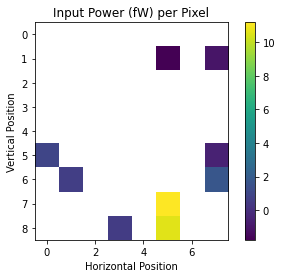

In [11]:
iv_series1.calc_absorbed_power()
dictionary_path = r'C:\Users\Tom\Desktop\SRON_data_single\FDM\analysis\conductance\pixelassignment.txt'
iv_series1.create_pixel_dictionary(dictionary_path)
iv_series1.plot_array(iv_series1.absorbed_power)

Another useful method is to plot the calculated Joule power for different black body temperatures with <code>plot_PT</code>. This is used for studying the behaviour of a single pixel, so the pixel number is required as input.

In [15]:
filelist_dir = r'C:\Users\Tom\Desktop\SRON_data_single\176pixel\analysis\pix02 - Edit.lis'
parameters = {'R_N': 0.16, 'R_fb': 9370, 'M_ratio': 1.45}
iv_series2 = IV_series('name', filelist_dir, parameters, double=False)

Loaded 18 datasets


C:\Users\Tom\anaconda3\envs\BachelorThesis\lib\site-packages\ipykernel_launcher.py:248: RuntimeWarning: invalid value encountered in double_scalars


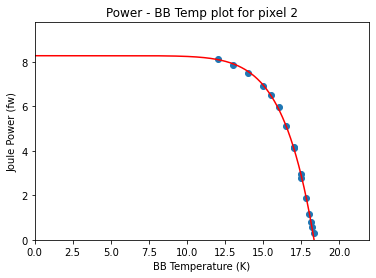

In [16]:
iv_series2.plot_PT(2)

<h1> Double Sided Data </h1>
Creating the <code>IV_series</code> object for double sided data is quite similar as the single sided data. It requires a name, path to the directory containing the data files and whether it is double sided or not. <br>
It also needs three parameters: <br>
Feedback resistance R_fb, coil ratio M_ratio, shunt resistance R_shunt in that specific order. <br>
Each <code>IV_double</code> object also needs to have some R_stray set before it can calculate values.

In [17]:
iv_series3 = IV_series('testing', 'C:/Users/Tom/Desktop/SRON_data_double_selected', [100002.9, 3.18541, 0.004567], double=True)

Loaded 9 datasets


In [19]:
for entry in iv_series3.data_double:    
    entry.R_stray = 1/1000
    entry.calc_all()  
    #entry.plot_IV()
    #entry.plot_PR()

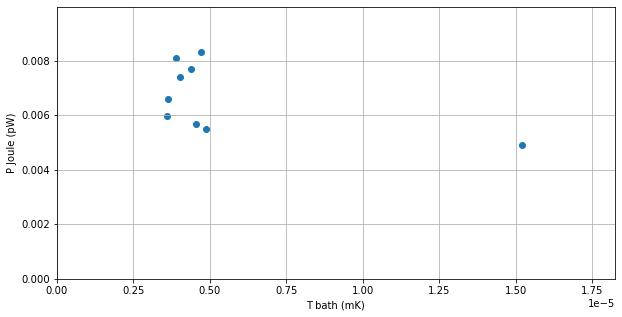

C:\Users\Tom\anaconda3\envs\BachelorThesis\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in power
C:\Users\Tom\anaconda3\envs\BachelorThesis\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in double_scalars


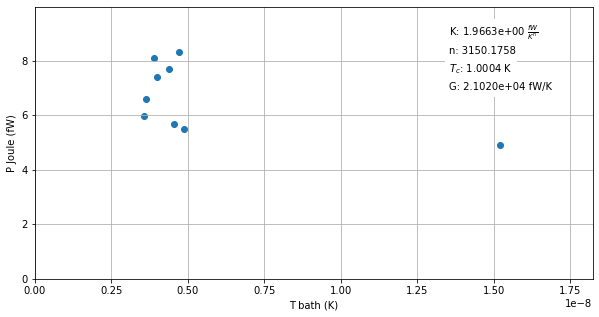

In [21]:
iv_series3.analyse_IV(0.0016, 0.001, 1000, debug=False)

<h1> Classifying Datasets </h1>

In [97]:
rootdir = r'C:\Users\Tom\Desktop\SRON_data_double'

classifier = Classifier(rootdir)

1

In [98]:
classifier.create_trainingdata()

15 files loaded
The above 0 file(s) were invalid and skipped,                         please check formats manually. Continuing...


In [99]:
classifier.iandv.head()

,Current 2 (I),V_fb 2 (V),Current 3 (I),V_fb 3 (V),Current 4 (I),V_fb 4 (V),Current 5 (I),V_fb 5 (V),Current 6 (I),V_fb 6 (V),...,Current 12 (I),V_fb 12 (V),Current 13 (I),V_fb 13 (V),Current 14 (I),V_fb 14 (V),Current 15 (I),V_fb 15 (V),Current 16 (I),V_fb 16 (V)
0,29.993226,-0.006142,150.010162,-0.048121,29.993226,-0.005990,29.993226,-0.005960,29.993226,-0.006070,...,29.993226,-0.004442,29.993226,-0.004239,150.010162,-0.368799,29.993226,-0.045017,29.993226,-0.045015
1,-29.993226,0.006802,-150.010162,0.063373,-29.993226,0.006826,-29.993226,0.006734,-29.993226,0.006562,...,-29.993226,0.005222,-29.993226,0.005075,-150.010162,0.388614,-29.993226,0.069588,-29.993226,0.069553
2,28.991023,-0.005899,139.998760,-0.028246,28.991023,-0.005781,28.991023,-0.005725,28.991023,-0.005862,...,28.991023,-0.004334,28.991023,-0.004144,139.998760,-0.336568,28.991023,-0.039507,28.991023,-0.039512
3,-28.991023,0.006135,-139.998760,0.041556,-28.991023,0.006135,-28.991023,0.006061,-28.991023,0.005888,...,-28.991023,0.004676,-28.991023,0.004510,-139.998760,0.357522,-28.991023,0.064217,-28.991023,0.064145
4,28.007041,-0.005334,129.994944,-0.024281,28.007041,-0.005273,28.007041,-0.005219,28.007041,-0.005330,...,28.007041,-0.003890,28.007041,-0.003724,129.994944,-0.304523,28.007041,-0.033997,28.007041,-0.033997


Change the features.xlsf file, such that it has labels. After this we can create the NN and do some testing.
Copy of features: 
nice_plot (Column J)
0
1
0
0
0
0
0
0
0
0
1
1
1
1
1

In [100]:
feature_folder = r'C:\Users\Tom\Desktop\Thesis_Notebook'

classifier.create_NN(feature_folder)
classifier.model

       mean       std  skewness  kurtosis  grad mean  grad std  grad skewness  \
0 -0.594449  1.261572  0.372979  0.352908   0.370235  1.055945      -0.658185   
1  1.213687  1.083901  0.362426  0.524826  -0.220327  0.886656      -0.704397   
2 -0.599016  1.230411  0.346932  0.386493   0.370956  1.187415      -0.694489   
3 -0.601281  1.006747  0.342287  0.447435   0.371584  0.993191      -0.675587   
4 -0.642439  0.822150  0.296690  0.469755   0.371990  0.673974      -0.600769   

   grad kurtosis  Unnamed: 8  nice_plot (Column J)  
0       0.701997         NaN                     0  
1       0.878599         NaN                     1  
2       0.775057         NaN                     0  
3       0.744916         NaN                     0  
4       0.591578         NaN                     0  
Epoch 1/150
2/2 [==============================] - 0s 0s/step - loss: 0.7106 - accuracy: 0.2500
Epoch 2/150
2/2 [==============================] - 0s 558us/step - loss: 0.7017 - accuracy: 0.2500


In [106]:
# Testing on other dataset:
other_rootdir = r'C:\Users\Tom\Desktop\SRON_data_single\2010-12-17'

classifier2 = Classifier(other_rootdir)
classifier2.create_trainingdata()

14 files loaded
The above 0 file(s) were invalid and skipped,                         please check formats manually. Continuing...


In [107]:
# Note that features.xlsf is now overwritten in feature_folder, so it contains no labels. Currently the label header 
# still needs to be added into the new features.xlsf file (name needs to match the one used in training).
# TODO: Simpler way to use the model on a features.xlsf file with only basic information, for easier and faster use. (Store headers in file?)
header_name = 'nice_plot (Column J)'
classifier.model = load_model('model ' + header_name)
classifier.test_NN(feature_folder)

        mean       std  skewness  kurtosis  grad mean  grad std  \
0   0.051454 -0.319331 -0.552823  0.089433  -0.329009 -0.758798   
1   0.127446 -0.346694 -0.412133 -0.116112  -0.168754 -0.885237   
2  -0.042412 -0.249418 -0.380683 -0.285127  -0.505825  0.353046   
3   0.215271 -0.338097 -1.106202  1.400101   0.043670 -0.367507   
4   0.035113 -0.277115 -0.465030 -0.197051  -0.404397  0.032227   
5   0.512288 -0.306538  0.548114 -0.183966   0.665261 -0.179167   
6   0.350445 -0.378299 -0.377715 -0.212634   0.208358 -1.104771   
7   0.790859  0.116682  1.866684 -0.111852   1.779410  1.627250   
8   0.338744 -0.364249 -1.749016  2.896076   0.182780 -0.817236   
9   0.551320 -0.193908  1.479260 -0.328662   1.116459  0.626892   
10  0.441023 -0.348930  1.296979 -0.812364   0.367203 -0.873433   
11 -3.354427  3.446482  0.082922 -0.827922  -2.680789  2.377994   
12  0.158019 -0.163259  0.041737 -0.887267   0.137305 -0.025111   
13 -0.175141 -0.277327 -0.272095 -0.422652  -0.411674 -0.00614

IndexError: index 9 is out of bounds for axis 0 with size 8

In [95]:
filelist_dir = r'C:\Users\Tom\Desktop\SRON_data_single\FDM\analysis\conductance\darkandoptical.lis'
iv_single = IV_series('hoi', filelist_dir, [], double=False)

In [133]:
rootdir = r'C:\Users\Tom\Desktop\SRON_data_single\FDM'

classifier = Classifier(rootdir)

In [134]:
classifier.create_trainingdata(plot=True)

['#readme.txt#', '.#readme.txt', 'FDM.zip', 'Pixel1_data.txt', 'readme.txt', 'readme.txt~', 'resonances_and_IV_curves_65mK.txt', 'resonances_and_IV_curves_65mK.txt~', 'resonances_and_IV_curves_65mK.xls', 'tesiv_pixel01_65mK_magnet000000uA_freq1161070Hz_20150709-174608.dat', 'tesiv_pixel01_BB22K_65mK_magnet000000uA_freq1161070Hz_20150714-163753.dat', 'tesiv_pixel01_BB22K_65mK_magnet000000uA_freq1161080Hz_20150714-172617.dat', 'tesiv_pixel01_steepness_65mK_magnet000000uA_freq1160910Hz_20150709-170156.dat', 'tesiv_pixel01_steepness_65mK_magnet000000uA_freq1160920Hz_20150709-170137.dat', 'tesiv_pixel01_steepness_65mK_magnet000000uA_freq1160930Hz_20150709-170119.dat', 'tesiv_pixel01_steepness_65mK_magnet000000uA_freq1160940Hz_20150709-170100.dat', 'tesiv_pixel01_steepness_65mK_magnet000000uA_freq1160950Hz_20150709-170041.dat', 'tesiv_pixel01_steepness_65mK_magnet000000uA_freq1160960Hz_20150709-170022.dat', 'tesiv_pixel01_steepness_65mK_magnet000000uA_freq1160970Hz_20150709-170003.dat', 'tes

In [131]:
classifier.iandv.head()

,V_bias 1,V_fb 1,V_bias 2,V_fb 2,V_bias 3,V_fb 3,V_bias 4,V_fb 4,V_bias 5,V_fb 5,...,V_bias 64,V_fb 64,V_bias 65,V_fb 65,V_bias 66,V_fb 66,V_bias 67,V_fb 67,V_bias 68,V_fb 68
0,1000.061035,195.521799,1000.061035,811.981312,1000.061035,137.195898,1000.061035,208.042882,1000.061035,206.083671,...,1999.969482,686.463731,1999.969482,628.992394,1999.969482,176.154637,1999.969482,158.560948,1999.969482,158.098326
1,995.025635,194.528645,995.025635,807.925301,995.025635,136.581658,995.025635,207.022528,995.025635,205.086526,...,1994.934082,684.731386,1994.934082,627.401951,1994.934082,175.703460,1994.934082,158.175655,1994.934082,157.716621
2,989.990234,193.553581,989.990234,803.872176,989.990234,135.894858,989.990234,205.965793,989.990234,204.070002,...,1990.051270,683.059819,1990.051270,625.827959,1990.051270,175.214112,1990.051270,157.777809,1990.051270,157.347887
3,984.954834,192.614488,984.954834,799.834299,984.954834,135.266914,984.954834,204.927820,984.954834,203.074750,...,1985.015869,681.343925,1985.015869,624.281604,1985.015869,174.824484,1985.015869,157.399787,1985.015869,156.954143
4,980.072021,191.629152,980.072021,795.901202,980.072021,134.577148,980.072021,203.967853,980.072021,202.068710,...,1979.980469,679.629766,1979.980469,622.685068,1979.980469,174.387717,1979.980469,156.991775,1979.980469,156.552239
